# Sentiment Prediction Model - Machine learning and Deep Learning 
## by Damilola Esan
## Introduction
> [The Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140) dataset, comprising around 1.6 million labeled tweets indicating positive or negative sentiments, offers a valuable resource for sentiment analysis tasks. In this data exploration process, we aim to gain insights into the sentiment distribution and identify patterns in the text data. The project's goal is to uncover valuable insights that can inform decision-making in marketing, customer feedback analysis, and brand reputation management.
>
> By delving into the Sentiment140 dataset, we seek to identify common sentiment expressions. The findings from this exploration will provide a deeper understanding of user sentiments expressed in social media text, enabling businesses and organizations to make data-driven decisions and optimize their strategies based on customer perceptions.

In [1]:
#Install required libraries
%pip install wordcloud nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.9/771.9 kB 59.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import BatchNormalization

import joblib
import io
import os

# NLTK Required downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/wsuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/wsuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/wsuser/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/wsuser/nltk_data...


True

In [3]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='project id', project_access_token='your project access token')
pc = project.project_context

from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space({'token':'your project access token'})

In [4]:
# Loading the dataset into a dataframe
data = wslib.load_data("sentiment_tweets.csv")

# Reading the CSV data file into a pandas DataFrame
data.seek(0)
df = pd.read_csv(data, encoding='latin-1', header=None,
                       names=['Sentiment', 'ID', 'Date', 'Flag', 'User', 'Tweet'])

## Preliminary Wrangling

In [5]:
# Randomly selecting a fraction of the dataset to optimise the process
positive = df[df['Sentiment'] == 4]
negative = df[df['Sentiment'] == 0]

p_quarter = int(len(positive) * 0.125)
n_quarter = int(len(negative) * 0.125)

positive_samples = positive.sample(n=p_quarter, random_state=42)
negative_samples = negative.sample(n=n_quarter, random_state=42)

tweet_df = pd.concat([positive_samples, negative_samples], ignore_index=True)

# Shuffling the rows of the reduced dataset to ensure randomness
tweet_df = tweet_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
# Quick overview of the dataset
print(tweet_df.shape)
tweet_df.head()

(200000, 6)


,Sentiment,ID,Date,Flag,User,Tweet
0,0,1880775287,Fri May 22 02:27:39 PDT 2009,NO_QUERY,ChrisTomLuke,@souljaboytellem drop me a dm. i might not be ...
1,4,1836079367,Mon May 18 07:19:52 PDT 2009,NO_QUERY,happyseaurchin,@swalkingtree hi sequoia be well!
2,0,1974317436,Sat May 30 12:53:00 PDT 2009,NO_QUERY,chelalala,"Nvm, they come off June 9."
3,4,1694684826,Mon May 04 03:42:44 PDT 2009,NO_QUERY,WhoisJohnLai,"@ElePhatt LOL thanks you, nice meeting you a..."
4,4,1932940972,Tue May 26 22:35:19 PDT 2009,NO_QUERY,Melissareeves1,is at SL Training Week and was just officially...


In [7]:
# More detailed overview of the dataset
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Sentiment  200000 non-null  int64 
 1   ID         200000 non-null  int64 
 2   Date       200000 non-null  object
 3   Flag       200000 non-null  object
 4   User       200000 non-null  object
 5   Tweet      200000 non-null  object
dtypes: int64(2), object(4)
memory usage: 9.2+ MB


In [8]:
# Descriptive statistics of the numerical features
tweet_df.describe()

,Sentiment,ID
count,200000.000000,2.000000e+05
mean,2.000000,1.999194e+09
std,2.000005,1.931002e+08
min,0.000000,1.467812e+09
25%,0.000000,1.956966e+09
50%,2.000000,2.002192e+09
75%,4.000000,2.177052e+09
max,4.000000,2.329205e+09


In [9]:
# Unique values present in the data
tweet_df.nunique()

Sentiment         2
ID           199976
Date         175308
Flag              1
User         148416
Tweet        199114
dtype: int64

In [10]:
# Checking for duplicated entries
tweet_df.duplicated().sum()

0

In [11]:
# Checking for null values
tweet_df.isnull().sum()

Sentiment    0
ID           0
Date         0
Flag         0
User         0
Tweet        0
dtype: int64

In [12]:
# Actual datatypes of each features in the dataset
for col in tweet_df.columns:
    print(col, type(tweet_df[col][0]))

Sentiment <class 'numpy.int64'>
ID <class 'numpy.int64'>
Date <class 'str'>
Flag <class 'str'>
User <class 'str'>
Tweet <class 'str'>


In [13]:
# Checking the unique values and count of values of the target variable
print(tweet_df.Sentiment.unique()),
tweet_df.Sentiment.value_counts()

[0 4]


0    100000
4    100000
Name: Sentiment, dtype: int64

### Quality Issues

1. The 'Tweet' column contains noise such as URLs, usernames and special characters.
2. The labels are imbalanced, where one sentiment value (positive(4), negative(0)) significantly outweighs the other, potentially impacting the performance of the machine learning model.
3. Text preproccessing such as uniform word casing (Lower) and removing stopwords

### Tidiness Issues

4. Irrelevant columns like 'ID,' 'Date,' 'Flag,' and 'User' that does not contribute to sentiment analysis.

### Other Issues to note include:

- Incomplete or truncated sentences in the 'Tweet' column due to Twitter's character limit may affect the accuracy of sentiment analysis and machine learning predictions.
- Lack of additional contextual information, such as user profiles or tweet topics, may limit the model's understanding of sentiments, especially in cases of sarcasm or irony.

## Data Exploration

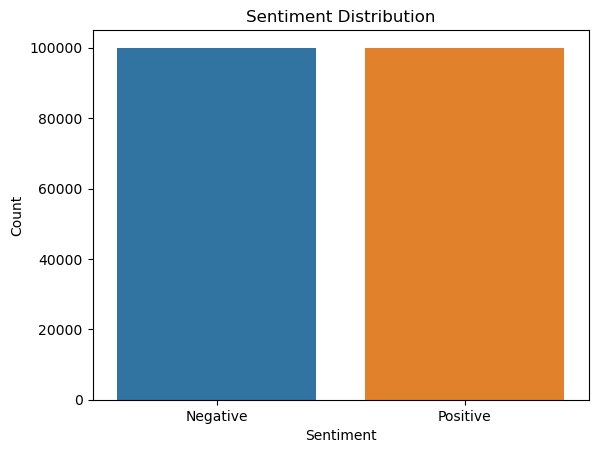

In [14]:
# Visualizing the sentiment distribution using a bar plot
sns.countplot(x='Sentiment', data=tweet_df)
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

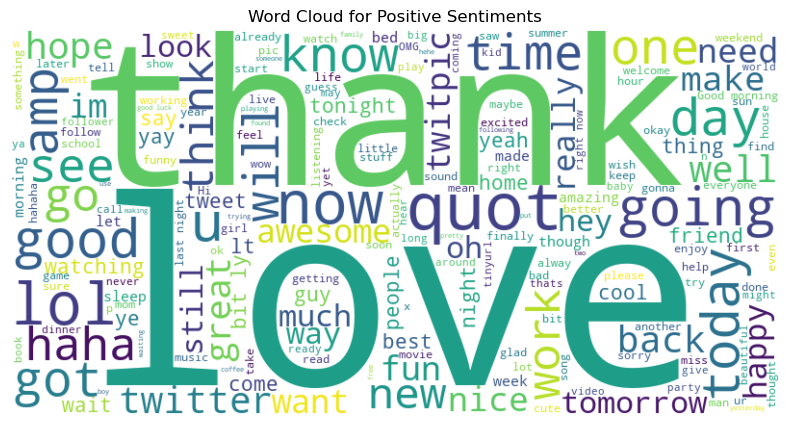

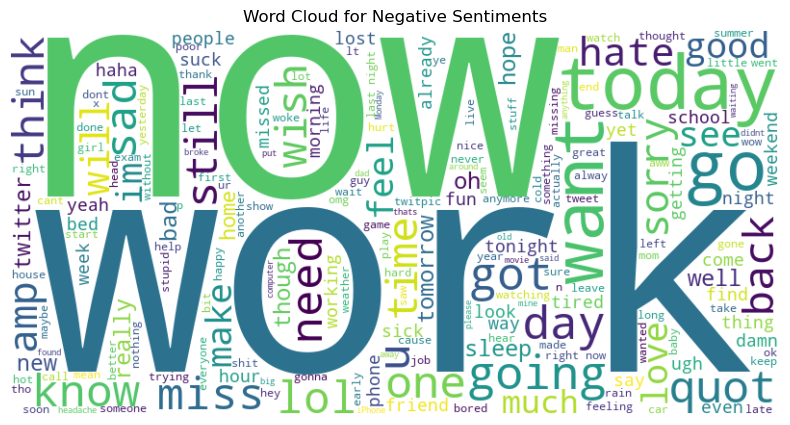

In [15]:
# Generating word clouds for positive and negative sentiments
positive_tweets = " ".join(tweet_df[tweet_df['Sentiment'] == 4]['Tweet'])
negative_tweets = " ".join(tweet_df[tweet_df['Sentiment'] == 0]['Tweet'])

# Word cloud for positive sentiments
positive_wordcloud = WordCloud(width=800, height=400, background_color='white' \
                              ).generate(positive_tweets)
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiments')
plt.axis('off')
plt.show()

# Word cloud for negative sentiments
negative_wordcloud = WordCloud(width=800, height=400, background_color='white' \
                              ).generate(negative_tweets)
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiments')
plt.axis('off')
plt.show()

In [16]:
# Checking the number of unique words present
def unique_words(tweets):
    words_set = set()
    for tweet in tweets:
        words = word_tokenize(tweet) 
        words_set.update(words) 
    return len(words_set)

unique_words = unique_words(tweet_df['Tweet'])
unique_words

199757

## Data Cleansing

In [17]:
# Removing noise from the tweets such as URLs, usernames and special characters
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|ftp\S+', '', tweet)
    # Remove usernames in the tweet (words starting with '@')
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove special characters
    tweet = re.sub(r'[^\w\s]', '', tweet)
    return tweet

tweet_df['Tweet'] = tweet_df['Tweet'].apply(clean_tweet)

In [18]:
# Preprocessing the tweet texts
def preprocess(tweet):
    tweets = tweet.lower().split()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = [lemmatizer.lemmatize(word) for word in tweets if not word in stop_words]
    new_text = " ".join(words)
    return new_text

tweet_df['Tweet'] = tweet_df['Tweet'].apply(preprocess)

In [19]:
# Convert positive sentiment label from 4 to 1 and leave negative as 0
tweet_df['Sentiment'] = tweet_df['Sentiment'].replace(4, 1)

tweet_df.Sentiment.value_counts()

0    100000
1    100000
Name: Sentiment, dtype: int64

In [20]:
# Removing unnecessary columns
tweet_df = tweet_df.drop(['ID', 'Date', 'Flag', 'User'], axis=1)

In [21]:
# Quick view of the cleaned dataset
tweet_df.sample(5)

,Sentiment,Tweet
24882,1,treasure island come
20074,0,wing
159110,1,hey follow one friend clicking link grow twitt...
93069,0,finished shooting h state baseball game went 1...
110619,1,eating bagel


In [22]:
# Writing and saving the prepared DataFrame to a single CSV file for future use
tweet_df.to_csv('prepared_data.csv', header=True, index=False)

## Feature Engineering

Customizing feature engineering for distinct models. For logistic regression and random forest, TF-IDF will be utilized. Meanwhile, for the LSTM model, we'll apply text-to-sequence, sequence padding, and GloVe pre-trained embedding.

In [23]:
# Applying TF-IDF vectorizer to the tweet texts
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, max_features=5000)  
tfidf_texts = tfidf_vectorizer.fit_transform(tweet_df['Tweet'])

In [24]:
# Tokenization and encoding of tweet texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweet_df['Tweet'])
vocab_size = len(tokenizer.word_index) + 1
encoded_texts = tokenizer.texts_to_sequences(tweet_df['Tweet'])

In [25]:
# Padding sequences for the encoded texts
max_len = max(len(sequence) for sequence in encoded_texts)
padded_texts = pad_sequences(encoded_texts, maxlen=max_len, padding='post')

In [26]:
# Loading the glove.6B.100d.txt file
glove = wslib.load_data("glove.6B.100d.txt")

glove.seek(0)
# Reading the pre-trained GloVe(6B-100d) embeddings
glove_embeddings = {}
with io.TextIOWrapper(glove, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.array(values[1:], dtype='float32')
        glove_embeddings[word] = embedding

## Train-Test Split

In [27]:
# Preparing features and target column for modeling
x_ml = tfidf_texts
x_dl = padded_texts
y = tweet_df['Sentiment']

In [28]:
# Spliting the data into training and testing sets
x_train_ml, x_test_ml, y_train_ml, y_test_ml = train_test_split(x_ml, y, test_size=0.2, 
                                                                random_state=42)

x_train_dl, x_test_dl, y_train_dl, y_test_dl = train_test_split(x_dl, y, test_size=0.2, 
                                                                random_state=42)

## Model Definition

>  Machine Learning Model

In [29]:
# Defining the models (Logistic Regression and Random Forest)
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier()

# Creating a parameter grid for hyperparameter tuning
lr_grid = {'C': [0.01, 0.1, 1],
           'solver': ['liblinear', 'lbfgs']}
rf_grid = {'n_estimators': [50, 100, 200],
           'max_depth': [None, 10, 20]}

# Creating a GridSearch for the model selection and hyperparameter tuning
lr_grid_search = GridSearchCV(lr, lr_grid, cv=3, scoring='accuracy')

rf_grid_search = GridSearchCV(rf, rf_grid, cv=3, scoring='accuracy')

>  Deep Learning Model

In [30]:
# Creating embedding matrix
matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    vector = glove_embeddings.get(word)
    if vector is not None:
        matrix[i] = vector

In [31]:
# Defining the model (Sequential LSTM)
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[matrix], 
                         input_length=max_len, trainable=False))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(BatchNormalization())
lstm_model.add(LSTM(32))
lstm_model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 100)           10184700  
                                                                 
 lstm (LSTM)                 (None, 33, 64)            42240     
                                                                 
 batch_normalization (BatchN  (None, 33, 64)           256       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                        

## Model Training

In [32]:
# Fitting the LR and RF models to the training data
lr_grid_search.fit(x_train_ml, y_train_ml)
lr_model = lr_grid_search.best_estimator_

rf_grid_search.fit(x_train_ml, y_train_ml)
rf_model = rf_grid_search.best_estimator_

lr_pred = lr_model.predict(x_test_ml)

rf_pred = rf_model.predict(x_test_ml)

In [33]:
# Quick evaluation of the models on the test data
lr_accuracy = lr_model.score(x_test_ml, y_test_ml)
rf_accuracy = rf_model.score(x_test_ml, y_test_ml)

print('Logistic Regression Accuracy: ', lr_accuracy)
print('Random Forest Accuracy: ', rf_accuracy)

Logistic Regression Accuracy:  0.765925
Random Forest Accuracy:  0.75425


In [34]:
# Fitting the LSTM model to the training data
history = lstm_model.fit(x_train_dl, y_train_dl, epochs=5, batch_size=64, 
               validation_data=(x_test_dl, y_test_dl))

predictions = lstm_model.predict(x_test_dl)
lstm_pred = (predictions > 0.5).astype(int)

Epoch 1/5
2500/2500 [==============================] - 85s 33ms/step - loss: 0.5741 - accuracy: 0.7218 - val_loss: 0.5391 - val_accuracy: 0.7277
Epoch 2/5
2500/2500 [==============================] - 84s 34ms/step - loss: 0.5135 - accuracy: 0.7556 - val_loss: 0.5141 - val_accuracy: 0.7381
Epoch 3/5
2500/2500 [==============================] - 82s 33ms/step - loss: 0.4964 - accuracy: 0.7654 - val_loss: 0.4973 - val_accuracy: 0.7592
Epoch 4/5
2500/2500 [==============================] - 85s 34ms/step - loss: 0.4843 - accuracy: 0.7730 - val_loss: 0.4923 - val_accuracy: 0.7661
Epoch 5/5
1250/1250 [==============================] - 11s 8ms/step


1250/1250 [==============================] - 11s 8ms/step - loss: 0.4992 - accuracy: 0.7675

LSTM Loss:  0.49915653467178345
LSTM Accuracy:  0.7674999833106995


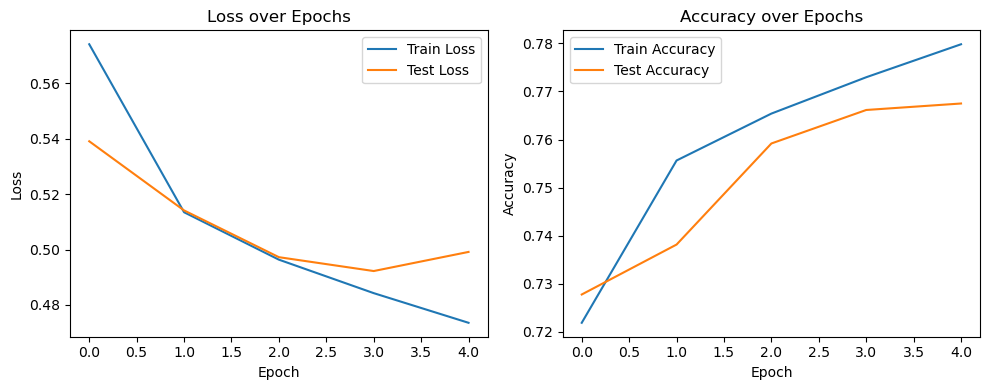

In [35]:
# Quick evaluation of the model on the test data
lstm_loss, lstm_accuracy = lstm_model.evaluate(x_test_dl, y_test_dl)

print('\nLSTM Loss: ', lstm_loss)
print('LSTM Accuracy: ', lstm_accuracy)

plt.figure(figsize=(10, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show();

## Model Evaluation

Logistic Regression Results:
Accuracy: 0.765925
Precision: 0.7601939393939394
Recall: 0.7802050159235668
F1 Score: 0.7700694973109697


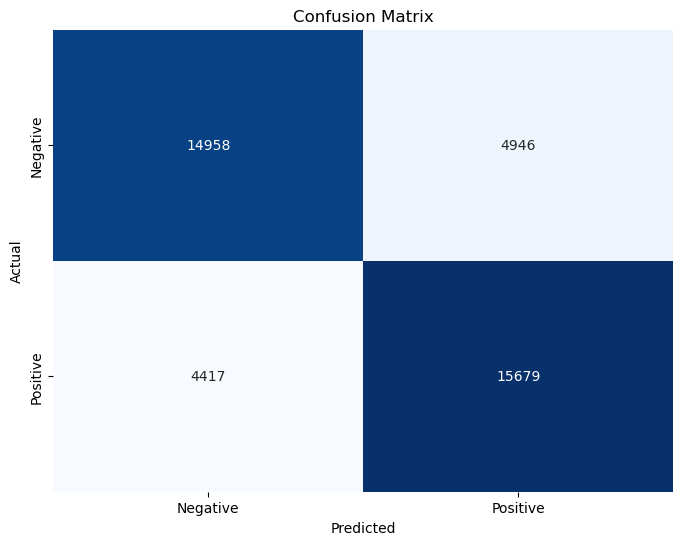


Random Forest Classifier Results:
Accuracy: 0.75425
Precision: 0.7588763364938471
Recall: 0.7487559713375797
F1 Score: 0.7537821861536921


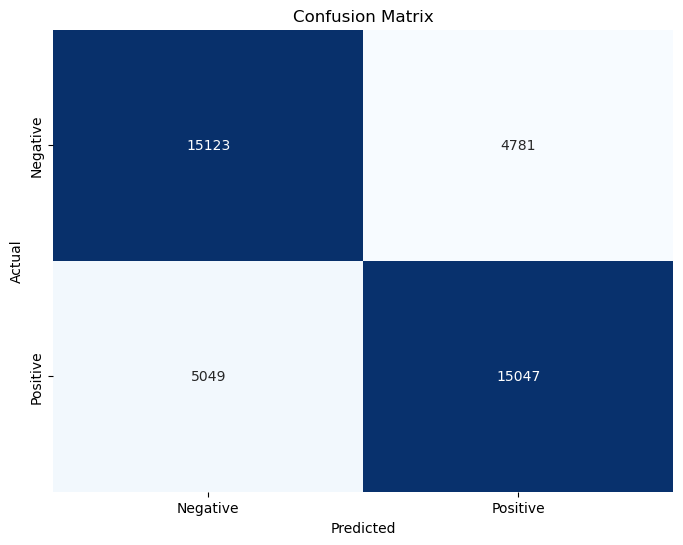


LSTM Model Results:
Accuracy: 0.7675
Precision: 0.7489163515632206
Recall: 0.8081707802547771
F1 Score: 0.7774161122014266


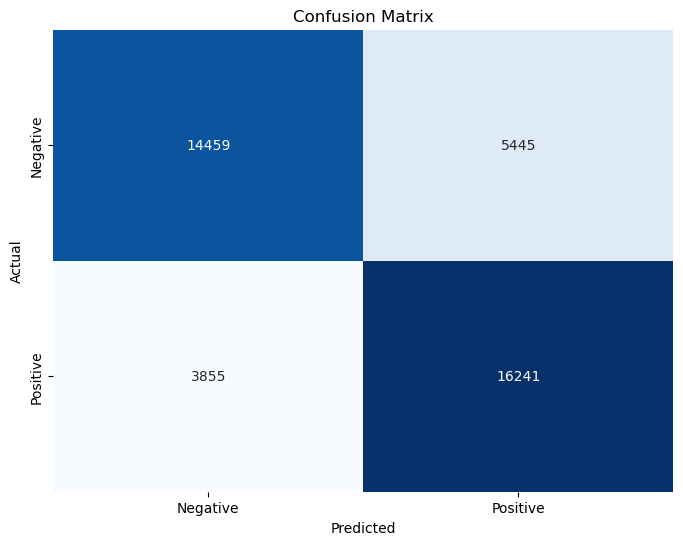

In [36]:
# Model Performance Evaluation
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show();
    
print("Logistic Regression Results:")
evaluate_model(y_test_ml, lr_pred)

print("\nRandom Forest Classifier Results:")
evaluate_model(y_test_ml, rf_pred)

print("\nLSTM Model Results:")
evaluate_model(y_test_dl, lstm_pred)

## Model Deployment

In [37]:
# Saving the models to Local for future deployment
lstm_model.save('lstm_model.keras')
joblib.dump(lr_model, 'lr_model.pkl')
joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']

In [38]:
# Loading the models from local
lstm_loaded = load_model('lstm_model.keras')
lr_loaded = joblib.load('lr_model.pkl')
rf_loaded = joblib.load('rf_model.pkl')

In [39]:
# Defining a function to utilize the loaded models
def predict(models, text):
    lstm_loaded, lr_loaded, rf_loaded = models
    
    # Converting text to TF-IDF or padded sequences depending on the model
    x_ml = tfidf_vectorizer.transform(text)
    x_dl = tokenizer.texts_to_sequences(text)
    x_dl = pad_sequences(x_dl, maxlen=max_len, padding='post')
    
    # Predicting sentiment using each model
    lstm_pred_new = lstm_loaded.predict(x_dl)
    lstm_pred_new = (lstm_pred_new > 0.5).astype(int)
    
    lr_pred_new = lr_loaded.predict(x_ml)
    rf_pred_new = rf_loaded.predict(x_ml)
    
    sentiment_predictions = { 'LSTM': lstm_pred_new,
                             'Logistic Regression': lr_pred_new,
                             'Random Forest': rf_pred_new }
    return sentiment_predictions

In [40]:
# Utilizing the models
sample = [
    "Absolutely love the new product! It exceeded my expectations",
    "The customer service was terrible. I had to wait for hours on the phone.",
    "Excited to see what the new brand has to offer. Their past products have been top-notch!",
    "I'm disappointed with the quality of the service. It's definitely not worth the price.",
    "The teaser for the upcoming launch got me intrigued. ",
    "The latest update to the app is causing so many bugs. It's frustrating and unusable."
    ]

# Sentiment predictions using the defined function
preds = predict((lstm_loaded, lr_loaded, rf_loaded), sample)

for model, preds in preds.items():
    print(f"Predictions using {model} model:")
    for text, sentiment in zip(sample, preds):
        print(f"Text: '{text}'\nSentiment: {'Positive' if sentiment == 1 else 'Negative'}")
    print("\n")


1/1 [==============================] - 1s 795ms/step
Predictions using LSTM model:
Text: 'Absolutely love the new product! It exceeded my expectations'
Sentiment: Positive
Text: 'The customer service was terrible. I had to wait for hours on the phone.'
Sentiment: Negative
Text: 'Excited to see what the new brand has to offer. Their past products have been top-notch!'
Sentiment: Positive
Text: 'I'm disappointed with the quality of the service. It's definitely not worth the price.'
Sentiment: Negative
Text: 'The teaser for the upcoming launch got me intrigued. '
Sentiment: Positive
Text: 'The latest update to the app is causing so many bugs. It's frustrating and unusable.'
Sentiment: Negative


Predictions using Logistic Regression model:
Text: 'Absolutely love the new product! It exceeded my expectations'
Sentiment: Positive
Text: 'The customer service was terrible. I had to wait for hours on the phone.'
Sentiment: Negative
Text: 'Excited to see what the new brand has to offer. Their pa

In [41]:
# Cleaning up local directory
os.remove('lstm_model.keras')
os.remove('lr_model.pkl')
os.remove('rf_model.pkl')